In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional
import pandas as pd
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

### Audiorecordings(from lectures)

dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])


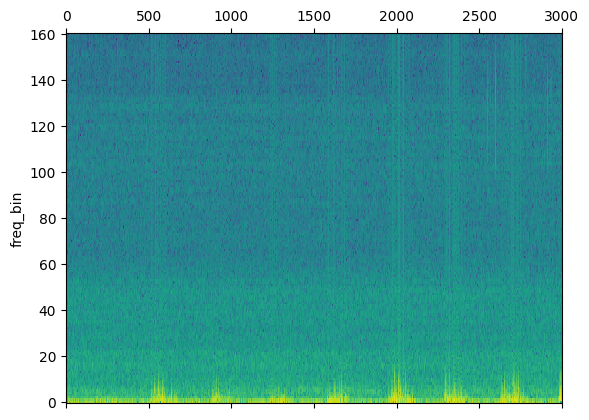

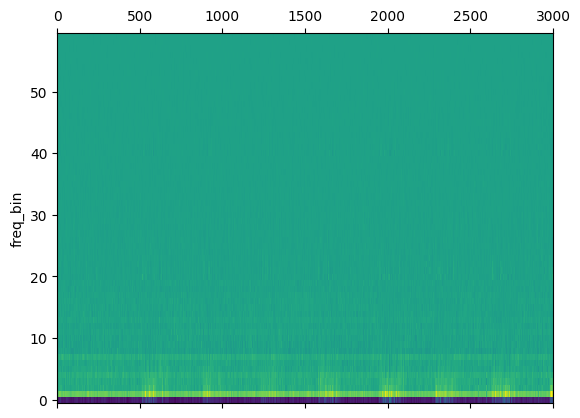

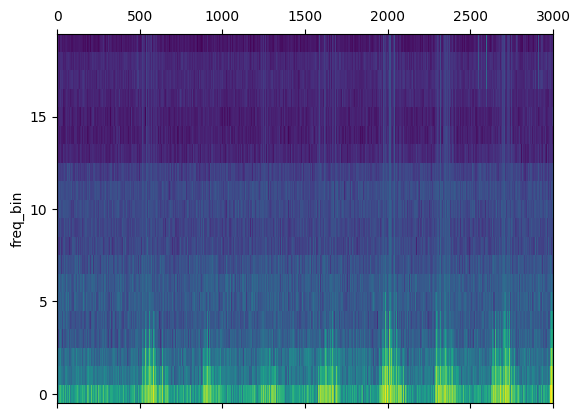

In [74]:
dataset = VBAIDataset('../bids_with_sensitive_recordings')
path = '../bids_with_sensitive_recordings/sub-0e2df8b3-a93f-4982-a82c-d96a5c64d153/ses-461EA3E8-4477-4F97-B091-D21F4006B2FC/audio/sub-0e2df8b3-a93f-4982-a82c-d96a5c64d153_ses-461EA3E8-4477-4F97-B091-D21F4006B2FC_Respiration-and-cough_rec-Respiration-and-cough-Breath-1'
data = torch.load(path + '.pt')
melfilterbank = data["melfilterbank"]
print(data.keys())
mfcc = data["mfcc"]
pt_spec = data["specgram"]
audio = Audio.from_file(path + '.wav')
audio = audio.to_16khz()
win_length = 20
hop_length = 10
nfft = None
features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T
pt_features_specgram = 10.0 * torch.log10(torch.maximum(pt_spec, torch.full(pt_spec.size(), fill_value=1e-10))).T
plot_spectrogram(features_specgram)
plot_spectrogram(mfcc.T)
plot_spectrogram(melfilterbank.T)

### Demographics

In [30]:
dg = pd.read_csv('../demographics.csv')
dg.head(1)

,Unnamed: 0,record_id,demographics_session_id,demographics_duration,demographics_completed_by___1,demographics_completed_by___2,demographics_completed_by___3,state_province,country,gender_identity,...,household_count,spouse_partner_sig_other,children,parent,grandparent,other_live_with,others_household_specify,transportation_yn,primary_transportation,q_generic_demographics_complete
0,0,8d5dc52b-e8aa-42e7-ae54-8f05c4667d39,B176636C-3330-4AB4-93A9-1E2305506407,173.0,True,False,False,Tennessee,USA,Female gender identity,...,4.0,No,Yes,Yes,No,No,NaN,Yes,Personal vehicle,Complete


In [31]:
X_train = dg[["record_id", "demographics_session_id"]]
Y_income = dg [["household_income_usa", "household_income_ca", "household_count"]]

Train = dg[["record_id", "demographics_session_id", "household_income_usa", "household_income_ca", "household_count"]]
Train.head(3)


,record_id,demographics_session_id,household_income_usa,household_income_ca,household_count
0,8d5dc52b-e8aa-42e7-ae54-8f05c4667d39,B176636C-3330-4AB4-93A9-1E2305506407,"$15,000 to $29,999",NaN,4.0
1,1b07b18b-26f9-405b-a466-29442306a7fe,8F8E68BB-E68C-4EA5-B71A-17D7AAE915C2,NaN,"$150,000 to $199,999",4.0
2,e5db3e0c-6589-4a15-a5e7-8a95e4ed34a5,B94FE4BC-79FF-46A1-86CC-628E2D77874E,NaN,"$50,000 to $99,999",1.0


In [32]:
print("Shape before filtering: ",Train.shape)
pre_train = Train[(pd.notna(Train['household_income_usa']) | pd.notna(Train['household_income_ca'])) &
                                   (~((Train['household_income_usa'] == 'Prefer not to answer') | 
                                      (Train['household_income_ca'] == 'Prefer not to answer')))]
print("Shape after filtering: ", pre_train.shape)


Shape before filtering:  (179, 5)
Shape after filtering:  (115, 5)


In [33]:
#label data: 0 - poverty, 1 - lower, 2 - middle, 3 - upper
pre_train_labeled = pd.DataFrame(pre_train)

for index, row in pre_train.iterrows():
    if pd.notna(pre_train.loc[index, "household_income_usa"]) and pre_train.loc[index, "household_count"] >= 3: # USD; HH >= 3
        income = pre_train.loc[index, "household_income_usa"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
    
    elif pd.notna(pre_train.loc[index, "household_income_usa"]): # USD; HH < 3
        income = pre_train.loc[index, "household_income_usa"]
        if income in ['< $15,000']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$15,000 to $29,999', '$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
        
    elif pd.notna(pre_train.loc[index, "household_income_ca"]):  # CA; HH >= 3
        income = pre_train.loc[index, "household_income_ca"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_ca")
        
    else:
        print(index)
        
   
one_hot = pd.get_dummies(pre_train_labeled['SES'], prefix='SES').astype(int)

pre_train_labeled = pd.concat([pre_train_labeled, one_hot], axis=1)

# display("Encoded labels: ", pre_train_labeled.head(3))
# print("Shape: ", pre_train_labeled.shape)

Y_label = pre_train_labeled.loc[:, "SES"]
print(Y_label.value_counts())

# Calculate the number of rows that correspond to the first 80%
num_rows = int(len(pre_train_labeled) * 0.8)
pre_train_labeled_first_80 = pre_train_labeled.iloc[:num_rows]

# Extract the "SES" column
Y_label_first_80 = pre_train_labeled_first_80.loc[:, "SES"]

# Get the value counts for the "SES" column
value_counts_first_80 = Y_label_first_80.value_counts()

print("train", value_counts_first_80)

# Calculate the number of rows that correspond to the first 80%
num_rows_2 = int(len(pre_train_labeled) * 0.1)
pre_train_labeled_first_80 = pre_train_labeled.iloc[num_rows:(num_rows+num_rows_2)]

# Extract the "SES" column
Y_label_first_80 = pre_train_labeled_first_80.loc[:, "SES"]

# Get the value counts for the "SES" column
value_counts_first_80 = Y_label_first_80.value_counts()

print("val ", value_counts_first_80)

# Calculate the number of rows that correspond to the first 80%
pre_train_labeled_first_80 = pre_train_labeled.iloc[(num_rows+num_rows_2):]

# Extract the "SES" column
Y_label_first_80 = pre_train_labeled_first_80.loc[:, "SES"]

# Get the value counts for the "SES" column
value_counts_first_80 = Y_label_first_80.value_counts()

print("test", value_counts_first_80)


SES
2.0    37
1.0    35
3.0    29
0.0    14
Name: count, dtype: int64
train SES
2.0    33
1.0    28
3.0    23
0.0     8
Name: count, dtype: int64
val  SES
0.0    5
1.0    3
3.0    2
2.0    1
Name: count, dtype: int64
test SES
3.0    4
1.0    4
2.0    3
0.0    1
Name: count, dtype: int64


### Audiofiles

In [99]:
# rainbow, story recall, Picture description
class RainbowMelfilterBankDataset(torch.utils.data.Dataset):
	def __init__(self, data):
		# self.segment_size = segment_size
		self.data = data
		
		# get location for every recording of rainbow passage
		for index, row in data.iterrows():
			subject = "sub-"+row['record_id']
			session = "ses-"+row['demographics_session_id']
			location = str("../bids_with_sensitive_recordings/" + subject + "/" + session + '/audio/'+subject+"_"+session+"_Rainbow-Passage_rec-Rainbow-Passage")
			if os.path.exists(location + '.wav'):
				self.data.at[index, "location"] = location
			else:
				# print all patients without Rainbow passage recording   
				print(location)
				# data.at[index, "location"] = None
				self.data = self.data.drop(index = index)
		self.data.reset_index(drop=True, inplace=True)
		# self.data = self.data.to_numpy()

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		self.segment_size = 1700
  
		data = torch.load(self.data.loc[idx, "location"]+'.pt')
		melfilterbank = data["melfilterbank"]
		
		if melfilterbank.size(0) > self.segment_size:
			d = (melfilterbank.size(0)-self.segment_size)//2
			melfilterbank = melfilterbank[d:d+self.segment_size, :]

		ses = self.data.loc[idx, ["SES_0.0", "SES_1.0", "SES_2.0", "SES_3.0"]].to_numpy(dtype=np.float32)
		ses = torch.tensor(ses, dtype=torch.float32)
		
		return {'signal': melfilterbank.T, 'SES': ses}

		# # get middle K seconds if audio is too long, pad with zeros if it is too short
		# if audio.size(0) > self.segment_size*16000:
		# 	d = (audio.size(0)-self.segment_size*16000)//2
		# 	audio = audio[d:d+self.segment_size*16000]
		# else:
		# 	audio = torch.nn.functional.pad(audio, (0,self.segment_size*16000-audio.size(0)), mode='constant', value=0)

	def analyze_length(self):
		total_length = 0
		min_val = 10e9
		max_val = 0
		for idx in range(len(self.data)):
			audio = Audio.from_file(self.data.loc[idx, "location"]+'.wav')
			audio = audio.to_16khz().signal.squeeze()
			length = audio.size(0)  # Number of samples in the audio
			min_val = min_val if min_val < length else length
			max_val = max_val if max_val > length else length
			total_length += length
		average_length = total_length / len(self.data)
		return average_length, min_val, max_val

In [100]:
# display(pre_train_labeled)
dataset = RainbowMelfilterBankDataset(pre_train_labeled)
avg, min_val, max_val = dataset.analyze_length()
print(avg, min_val, max_val)

../bids_with_sensitive_recordings/sub-f2f58f0a-4ffb-46b2-b95f-c4950ad82a83/ses-5A73EFCE-CD0B-4CB6-BFD2-976227E43C0C/audio/sub-f2f58f0a-4ffb-46b2-b95f-c4950ad82a83_ses-5A73EFCE-CD0B-4CB6-BFD2-976227E43C0C_Rainbow-Passage_rec-Rainbow-Passage
../bids_with_sensitive_recordings/sub-2e59cc45-df19-4e2d-a1d8-60c46cf47a63/ses-5E054A0F-CFA2-46AF-9248-14949EAB163E/audio/sub-2e59cc45-df19-4e2d-a1d8-60c46cf47a63_ses-5E054A0F-CFA2-46AF-9248-14949EAB163E_Rainbow-Passage_rec-Rainbow-Passage
../bids_with_sensitive_recordings/sub-a2044905-fcf0-4971-8567-7d5a772f431c/ses-685E523B-E78B-4F51-AB4B-F199B1269F8C/audio/sub-a2044905-fcf0-4971-8567-7d5a772f431c_ses-685E523B-E78B-4F51-AB4B-F199B1269F8C_Rainbow-Passage_rec-Rainbow-Passage
464351.10714285716 282947 808798


In [180]:
X = pre_train_labeled[['record_id', 'demographics_session_id']]
y = pre_train_labeled[['SES', 'SES_0.0', 'SES_1.0', 'SES_2.0', 'SES_3.0']]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

print("train: ", y_train.value_counts())
print("validation: ", y_val.value_counts())
print("test: ", y_test.value_counts())

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

N = len(pre_train_labeled)

train_dataset = RainbowMelfilterBankDataset(train_df)
val_dataset = RainbowMelfilterBankDataset(val_df)
test_dataset = RainbowMelfilterBankDataset(test_df)

# print(train_dataset[1])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=6, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=66, shuffle=False)

for batch in train_dataloader:
    print(batch['signal'].shape)
    print(batch['SES'].shape)
    break


train:  SES  SES_0.0  SES_1.0  SES_2.0  SES_3.0
2.0  0        0        1        0          30
1.0  0        1        0        0          28
3.0  0        0        0        1          23
0.0  1        0        0        0          11
Name: count, dtype: int64
validation:  SES  SES_0.0  SES_1.0  SES_2.0  SES_3.0
1.0  0        1        0        0          3
2.0  0        0        1        0          3
3.0  0        0        0        1          3
0.0  1        0        0        0          2
Name: count, dtype: int64
test:  SES  SES_0.0  SES_1.0  SES_2.0  SES_3.0
1.0  0        1        0        0          4
2.0  0        0        1        0          4
3.0  0        0        0        1          3
0.0  1        0        0        0          1
Name: count, dtype: int64
../bids_with_sensitive_recordings/sub-f2f58f0a-4ffb-46b2-b95f-c4950ad82a83/ses-5A73EFCE-CD0B-4CB6-BFD2-976227E43C0C/audio/sub-f2f58f0a-4ffb-46b2-b95f-c4950ad82a83_ses-5A73EFCE-CD0B-4CB6-BFD2-976227E43C0C_Rainbow-Passage_rec-Rainbo

### CNN Model

In [191]:
class CNN_1D(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(20, 64, kernel_size=11, stride=32, padding=0)
        self.mp = nn.MaxPool1d(kernel_size=3, stride=3)
        self.dropout = nn.Dropout(0.5)
  
        # Calculate the input size to the linear layer
        self.fc_input_size = self._calculate_fc_input_size()
  
        self.fc = torch.nn.Linear(self.fc_input_size, num_classes)

    def forward(self, x):
        x = self.mp(torch.nn.functional.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)  # Apply dropout before the linear layer
        x = self.fc(x)
        return x

    def _calculate_fc_input_size(self):
        # Example calculation assuming input size (16, 20, 1700)
        x = torch.randn(1, 20, 1700)
        x = self.mp(nn.functional.relu(self.conv1(x)))
        return x.view(x.size(0), -1).size(1)



In [192]:
# cnn = CNN_1D(4)
cnn = CNN_1D(num_classes=4)
_ = summary(cnn, (20, 1700))
# for batch in train_dataloader:
#     out = cnn(batch['signal'].unsqueeze(1)).squeeze(1)[0]
#     out = torch.tensor([0.1, 0.2, 1, 10])
#     print(out)
#     print(torch.nn.functional.softmax(out))
#     print()
#     break

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 53]          14,144
         MaxPool1d-2               [-1, 64, 17]               0
           Dropout-3                 [-1, 1088]               0
            Linear-4                    [-1, 4]           4,356
Total params: 18,500
Trainable params: 18,500
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.13
Forward/backward pass size (MB): 0.04
Params size (MB): 0.07
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


In [193]:
def eval(model, dataloader, verbose = False):
    model.eval()
    acc = 0
    total = 0
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(batch['signal'])
            if verbose:
                print(outputs)
        for i in range(len(batch['signal'])):
            _, predicted = torch.max(outputs, 1)
            _, ground_truth = torch.max(batch['SES'], 1)
            if verbose:
                print(ground_truth)
            acc += (predicted == ground_truth).sum().item()
            total += ground_truth.size(0)
    if verbose:
        return acc/total, outputs
    return acc/total	

optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

num_epochs = 50
best_val_acc = 0

for epoch in range(num_epochs):
    cnn.train()
    closs = []
    for batch in train_dataloader:        
        optimizer.zero_grad()
        outputs = cnn(batch['signal'])
        loss = criterion(outputs, batch['SES'].argmax(dim=1))
        closs += [loss.item()] * len(batch['signal'])
        loss.backward()
        optimizer.step()
    scheduler.step()

    val_acc = eval(cnn, val_dataloader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), 'mymodel.pth')
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {sum(closs)/len(closs)}, Val Acc: {val_acc}')


Epoch 1/50, Loss: 11.209730847676594, Val Acc: 0.36065573770491804
Epoch 2/50, Loss: 7.936069064670139, Val Acc: 0.36065573770491804
Epoch 3/50, Loss: 8.039097330305312, Val Acc: 0.36065573770491804
Epoch 4/50, Loss: 7.57408668729994, Val Acc: 0.26229508196721313
Epoch 5/50, Loss: 8.188416735331218, Val Acc: 0.2459016393442623
Epoch 6/50, Loss: 7.521955129835341, Val Acc: 0.2459016393442623
Epoch 7/50, Loss: 6.188370217217339, Val Acc: 0.2786885245901639
Epoch 8/50, Loss: 5.431650691562229, Val Acc: 0.2786885245901639
Epoch 9/50, Loss: 5.341031922234429, Val Acc: 0.26229508196721313
Epoch 10/50, Loss: 5.216808891296386, Val Acc: 0.3442622950819672
Epoch 11/50, Loss: 5.118870136472914, Val Acc: 0.3442622950819672
Epoch 12/50, Loss: 4.762928512361315, Val Acc: 0.3442622950819672
Epoch 13/50, Loss: 4.07746852238973, Val Acc: 0.3442622950819672
Epoch 14/50, Loss: 4.714796352386474, Val Acc: 0.3442622950819672
Epoch 15/50, Loss: 4.225819359885322, Val Acc: 0.3442622950819672
Epoch 16/50, Lo

In [184]:
cnn.load_state_dict(torch.load('./mymodel.pth'))
test_acc, outputs = eval(cnn, test_dataloader, verbose = True)
print(outputs.argmax(dim=-1))
print("      ", y_test.loc[:, "SES"].to_numpy())
print('TestACC:{:.4f}'.format(test_acc))

tensor([[ 2.4214,  1.6169,  8.1287,  6.1230],
        [-1.1731,  3.0773,  5.4700,  7.4657],
        [ 2.8946,  5.7812,  9.5089,  7.3313],
        [-2.2867,  4.4742,  7.1680,  3.5421],
        [-1.4451,  2.9343,  4.0217,  7.0116],
        [-0.4898,  3.1630,  4.5432,  5.1717],
        [ 2.9422,  3.4843, 10.1975,  7.7057],
        [ 0.6628, -1.5870, 10.7323,  6.4862],
        [ 3.5022,  7.9474, 11.9285, 10.6058],
        [-3.6852,  7.5792,  3.4178,  3.1009],
        [ 4.9339,  6.9436, 11.4609, 10.2175]])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([1, 1, 1, 3, 0, 2, 3, 1, 2, 2, 2])
tensor([2, 3, 2, 2, 3, 3, 2, 2,

In [18]:
# Just for plotting

test_loss, test_accuracy = cnn.evaluate(test_features, test_labels)
print(f'Test Accuracy: {test_accuracy}')


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

test_predictions = (cnn.predict(test_features) > 0.5).astype("int32")

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Race_5', 'Race_5'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


AttributeError: 'CNN2' object has no attribute 'evaluate'

: 